# InCURA Tutorial

## Generation of the InCURA gene-by-TFBS Matrix and Downstream Processing


### Import of packages

In [2]:
import scanpy as sc
import decoupler as dc
import anndata as ad


import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import scanpy as sc
import scipy.cluster.hierarchy as sch
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import re
from datetime import datetime

# Needed for some plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Create a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

pd.set_option('display.max_rows', 500)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
custom_colors = ['#e8ba41', '#b1a73e', '#b93c6d', '#b4d6e7', 'grey']

## InCURA Preprocessing

### Load data

In [4]:
# Set path variable
path = 'tutorial_data/'

In [10]:
#Load motif scanning results
fimo = pd.read_csv(path + 'fimo.tsv', sep='\t')

### Generate gene-by-TFBS matrix

In [11]:
# Preprocess fimo output
## Remove rows with missing values
fimo.dropna(subset=['sequence_name'], inplace=True)

## Extract chromosome and gene name
fimo['chrom'] = fimo['sequence_name'].str.split('_').str[1]
fimo['gene'] = fimo['sequence_name'].str.split('_').str[0]

## Remove seq name column
fimo.drop(columns=['sequence_name', 'motif_alt_id'], inplace=True)

## Convert motif to uppercase
fimo['motif_id'] = fimo['motif_id'].str.upper()

In [12]:
# Collapse entries for the same gene, motif, and strand with overlapping binding sites

def summarize_binding_sites(df):
    # Sort the DataFrame by genes, motif, strand, and start position
    sorted_df = df.sort_values(by=['gene', 'motif_id', 'strand', 'start'])

    # Initialize empty lists to store the summarized data
    genes = []
    starts = []
    ends = []
    motifs = []
    scores = []
    strands = []

    # Iterate over the sorted DataFrame and compute the summary statistics
    current_gene = None
    current_motif = None
    current_strand = None
    current_start = None
    current_end = None
    total_score = 0
    count = 0

    for _, row in sorted_df.iterrows():
        gene = row['gene']
        motif = row['motif_id']
        strand = row['strand']
        start = row['start']
        end = row['stop']
        score = row['score']

        # Check if it's a new group or if the current row overlaps with the previous one
        if gene != current_gene or motif != current_motif or strand != current_strand or start > current_end:
            # Append the summarized data to the lists
            if current_gene is not None:
                genes.append(current_gene)
                starts.append(current_start)
                ends.append(current_end)
                motifs.append(current_motif)
                scores.append(total_score / count)
                strands.append(current_strand)

            # Update the current group information
            current_gene = gene
            current_motif = motif
            current_strand = strand
            current_start = start
            current_end = end
            total_score = score
            count = 1
        else:
            # Update the end position and accumulate the score
            current_end = max(current_end, end)
            total_score += score
            count += 1

    # Append the last group
    if current_gene is not None:
        genes.append(current_gene)
        starts.append(current_start)
        ends.append(current_end)
        motifs.append(current_motif)
        scores.append(total_score / count)
        strands.append(current_strand)

    # Create a new DataFrame with the summarized data
    summary_df = pd.DataFrame({
        'symbols': genes,
        'start': starts,
        'end': ends,
        'motif': motifs,
        'score': scores,
        'strand': strands
    })

    return summary_df


In [13]:
summary_fimo = summarize_binding_sites(fimo)
summary_fimo

,symbols,start,end,motif,score,strand
0,1700019D03Rik,53020444.0,53020452.0,ARID3A,8.89349,-
1,1700019D03Rik,53019792.0,53019802.0,ARID3B,14.45560,+
2,1700019D03Rik,53021012.0,53021022.0,ARID3B,13.06670,+
3,1700019D03Rik,53019812.0,53019822.0,ARID3B,13.15560,-
4,1700019D03Rik,53021011.0,53021021.0,ARID3B,13.06670,-
...,...,...,...,...,...,...
89429,Zyx,42349504.0,42349518.0,ZFP281,14.03200,+
89430,Zyx,42349980.0,42349994.0,ZFP281,13.54400,+
89431,Zyx,42349532.0,42349548.0,ZFP410,13.49550,-
89432,Zyx,42348225.0,42348241.0,ZFP691,13.73000,-


In [10]:
# Optional: Save the summarized DataFrame to a TSV file
summary_fimo.to_csv(path + 'summary_fimo.tsv', sep='\t', index=False)

In [17]:
# Create a binary gene-by-TFBS matrix 

def create_binary_matrix(data_frame):
    # Get unique genes and TFs
    genes = data_frame['symbols'].unique()
    tfs = data_frame['motif'].unique()

    # Create an empty binary matrix
    binary_matrix = np.zeros((len(genes), len(tfs)), dtype=int)

    # Iterate over the rows in the data frame
    for _, row in data_frame.iterrows():
        gene_idx = np.where(genes == row['symbols'])[0][0]
        tf_idx = np.where(tfs == row['motif'])[0][0]
        binary_matrix[gene_idx, tf_idx] = 1

    # Create a data frame from the binary matrix
    binary_data_frame = pd.DataFrame(binary_matrix, index=genes, columns=tfs)

    return binary_data_frame

In [18]:
# Generate binary matrix
binary_matrix = create_binary_matrix(summary_fimo)
binary_matrix.sort_index(inplace=True, axis=1)
binary_matrix

,AHCTF1,AHR,AR,ARID3A,ARID3B,ARID5A,ARID5B,ARNT,ARNTL,ATF1,...,ZBTB6,ZBTB7B,ZFP128,ZFP281,ZFP335,ZFP410,ZFP652,ZFP691,ZFP740,ZFX
1700019D03Rik,0,0,0,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1700025G04Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1810026B05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4930417O13Rik,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4930453N24Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zmiz1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
Znrf2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
Znrf3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
Zswim6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [13]:
# Save binary matrix to TSV file
binary_matrix.to_csv(path + 'binary_matrix.tsv', sep='\t')

In [19]:
# Create gene-by-TFBS matrix with counts of interactions

def create_tf_gene_matrix(df):
    """
    Create a TF-gene matrix as a pandas DataFrame where the value represents 
    how often a gene appears as a target of a given TF.

    Parameters:
    - df (pd.DataFrame): A DataFrame with columns ['symbols', 'motif'],
                         where each row represents a TF binding event.

    Returns:
    - tf_gene_df (pd.DataFrame): A DataFrame of shape (num_TFs, num_genes) 
                                 with counts of TF-gene interactions.
    """
    # Count occurrences of (TF, gene) pairs
    interaction_counts = df.groupby(["motif", "symbols"]).size().unstack(fill_value=0).T

    return interaction_counts

In [20]:
# Generate gene-by-TFBS count matrix
count_matrix = create_tf_gene_matrix(summary_fimo)
count_matrix.sort_index(inplace=True, axis=1)
count_matrix

motif,AHCTF1,AHR,AR,ARID3A,ARID3B,ARID5A,ARID5B,ARNT,ARNTL,ATF1,...,ZBTB6,ZBTB7B,ZFP128,ZFP281,ZFP335,ZFP410,ZFP652,ZFP691,ZFP740,ZFX
symbols,,,,,,,,,,,,,,,,,,,,,
1700019D03Rik,0,0,0,1,4,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1700025G04Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,5
1810026B05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,0,0,0,5
4930417O13Rik,1,0,0,2,4,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4930453N24Rik,0,0,0,0,1,2,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zmiz1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,2,0,0,0,2
Znrf2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
Znrf3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3


In [179]:
count_matrix.to_csv(path + 'InCURA_count_matrix.tsv', sep='\t')

### Clustering

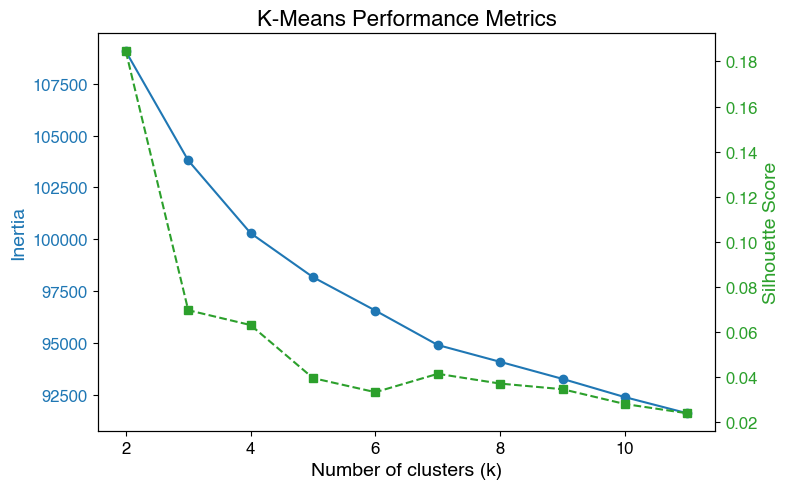

In [22]:

X = count_matrix

# Range of cluster numbers to test
k_values = range(2, 12)  

# Store scores
inertias = []
silhouette_scores = []

# Loop over k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot both metrics
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)', fontsize=14)
ax1.set_ylabel('Inertia', color=color, fontsize=14)
ax1.plot(k_values, inertias, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

ax2 = ax1.twinx()  # Second axis for silhouette
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=14)
ax2.plot(k_values, silhouette_scores, marker='s', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.tick_params(axis='x', labelsize=12)

plt.title('K-Means Performance Metrics', fontsize=16)
fig.tight_layout()
plt.savefig(path + f'KMeans_performance_metrics_{timestamp}.svg', bbox_inches='tight')
plt.show()


/home/lorna/miniconda3/envs/gretabench/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


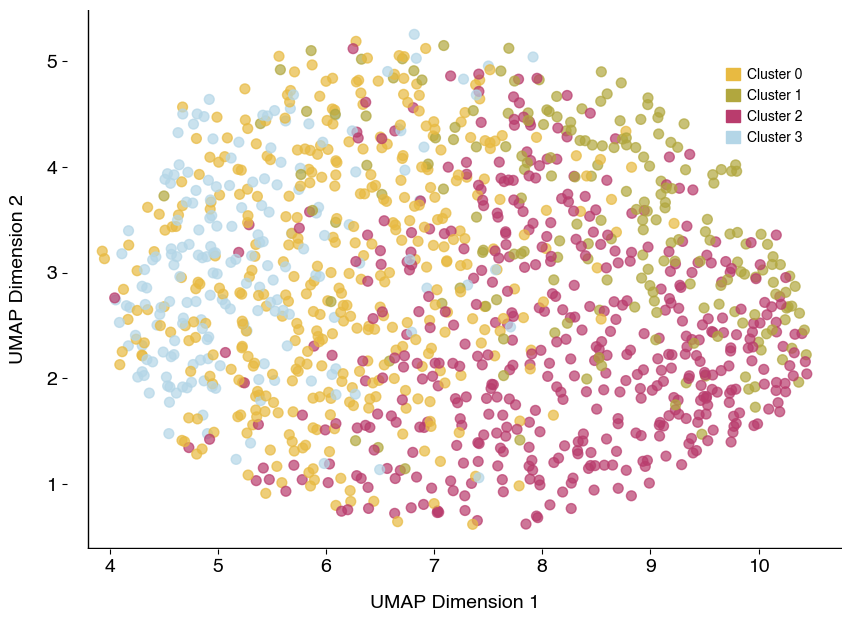

In [25]:
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, )
labels = kmeans.fit_predict(count_matrix)
df_labels = pd.DataFrame()

# Add labels to DataFrame
df_labels['Cluster'] = labels

# Step 2: Reduce Dimensions Using UMAP
umap = UMAP(n_components=2, random_state=42, metric='canberra', n_neighbors=15, min_dist=0.2)
embedding = umap.fit_transform(count_matrix)

# Step 3: Create a Discrete Color Palette
palette = custom_colors  # Choose a palette with n_clusters colors
colors = [palette[label] for label in labels]

# Step 4: Visualize the Clusters
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
xmin = 3.8
xmax = 12.0
ymin = 0.4
ymax = 8.5
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=1))
ax.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black', linewidth=1))

scatter = plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=colors, s=50, alpha=0.7
)

# Step 5: Add Legend
legend_patches = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(n_clusters)]
plt.legend(handles=legend_patches, loc=(0.85, 0.75), facecolor='whitesmoke')

plt.xlabel("UMAP Dimension 1", labelpad=14, fontsize=14)
plt.ylabel("UMAP Dimension 2", labelpad=14, fontsize=14)
plt.savefig(path + f'Kmeans_count_umap_k4_{timestamp}.svg', bbox_inches='tight')
plt.show()

### Save main results

#### The following files are central outputs from the InCURA workflow. The data frame stores the gene-by-TFBS matrix together with the cluster labels. Below we save the cluster assignments of the genes in separate files. Both can easily be saved as excel files for easy visual inspection. 

In [27]:
# Save count matrix with cluster labels
count_df = count_matrix.copy()
count_df['Cluster'] = labels

count_df.to_csv(path + f'count_df_kmeans_labels_k5_{timestamp}.tsv', sep='\t')
#Optional: Save as Excel file
#count_df.to_excel(path + f'count_df_kmeans_labels_k5_{timestamp}.xlsx', sep='\t')

In [29]:
# Save genes in each cluster to separate files
for i in count_df['Cluster'].unique():
    pd.Series(count_df[count_df['Cluster'] == i].index).to_csv(path + f'Count_cluster{i}_genes_k5.tsv', sep='\t', index=False)
    #Optional: Save as Excel file
    #pd.Series(cosine_dist_df[cosine_dist_df['Cluster'] == i].index).to_excel(dataset + f'random_Count_cluster{i}_genes_k5.xlsx', index=False)
 

#### If you would like to know more about possible downstream analyses please also check the tutorials for checking enriched gene signatures and identifying driver TFs! 